# Importing Libraries

In [79]:
import pandas as pd
import tensorflow as tf
import torch
import transformers
from transformers import BertTokenizer
import matplotlib.pyplot as plt
import matplotlib as mpl
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig
import warnings
warnings.filterwarnings('ignore')

cmap = mpl.cm.get_cmap('coolwarm')

**> GPU check**

In [3]:
if torch.cuda.is_available():

    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


**> Importing Data**

(1378, 4)


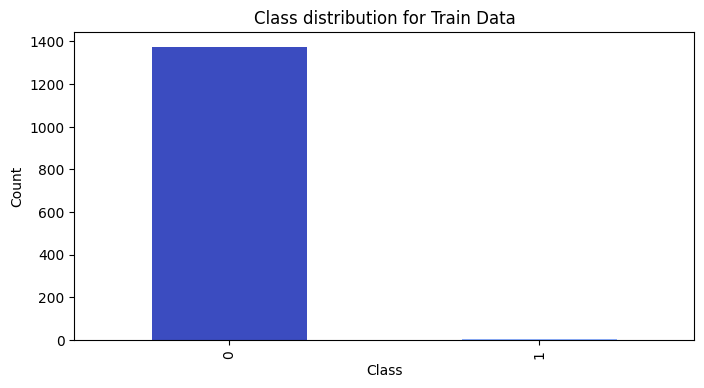

In [10]:
df = pd.read_csv(r'llm-detect-ai-generated-text/train_essays.csv')

print(df.shape)

# Show distribution of answers using a bar plot
plt.figure(figsize=(8, 4))
df.generated.value_counts().plot.bar(color=[cmap(0.0), cmap(0.25), cmap(0.65), cmap(0.9), cmap(1.0)])
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

**> We have some serious data imbalance problem. Let's fix  it by importing some external data**

Using the below datasets to fix our imbalance issue

[https://www.kaggle.com/datasets/alejopaullier/argugpt/](http://)

https://www.kaggle.com/datasets/thedrcat/daigt-proper-train-dataset/

In [12]:
ext_df1 = pd.read_csv('daigt-proper-train-dataset/train_drcat_04.csv')
ext_df2 = pd.read_csv('argugpt/argugpt.csv')[['id','text','model']]
ext_df2['generated'] = 1

final_df = pd.concat([df[['text', 'generated']], ext_df1.rename(columns={'label' : 'generated'})[['text', 'generated']], ext_df2[['text', 'generated']]], axis=0)

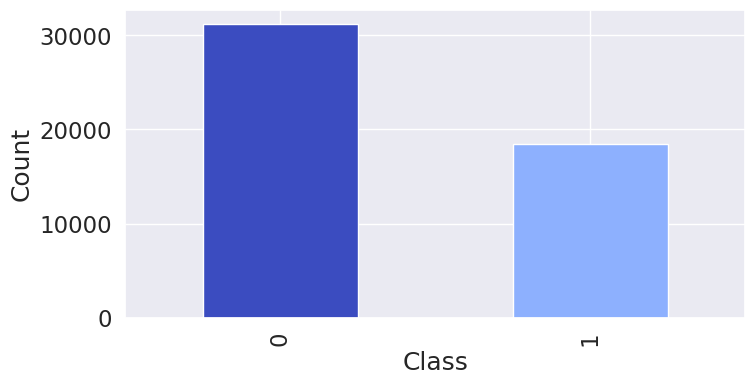

In [216]:
plt.figure(figsize=(8, 4))
final_df.generated.value_counts().plot.bar(color=[cmap(0.0), cmap(0.25), cmap(0.65), cmap(0.9), cmap(1.0)])
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

**Hmm...We still have imbalance problem. We will address this later**

In [13]:
#Converting the variables into lists
sentences = final_df.text.values
labels = final_df.generated.values

**Importing the Tokenizer from transformers library to tokenize the input data.**

In [215]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [16]:
#Encoding the input tokens
input_ids = []

for sent in sentences:
    encoded_sent = tokenizer.encode(
                        sent,                    
                        add_special_tokens = True
                   )

    input_ids.append(encoded_sent)

print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Token indices sequence length is longer than the specified maximum sequence length for this model (709 > 512). Running this sequence through the model will result in indexing errors


Original:  Cars. Cars have been around since they became famous in the 1900s, when Henry Ford created and built the first ModelT. Cars have played a major role in our every day lives since then. But now, people are starting to question if limiting car usage would be a good thing. To me, limiting the use of cars might be a good thing to do.

In like matter of this, article, "In German Suburb, Life Goes On Without Cars," by Elizabeth Rosenthal states, how automobiles are the linchpin of suburbs, where middle class families from either Shanghai or Chicago tend to make their homes. Experts say how this is a huge impediment to current efforts to reduce greenhouse gas emissions from tailpipe. Passenger cars are responsible for 12 percent of greenhouse gas emissions in Europe...and up to 50 percent in some carintensive areas in the United States. Cars are the main reason for the greenhouse gas emissions because of a lot of people driving them around all the time getting where they need to go.

**As we look at below our maximum token length of a sentence in our training data is 2371. Since BERT has context limit of 512, let's not nuke the BERT and change its context length. Instead let's only take the input sentences which has less than 512 tokens.**

In [17]:
print('Max sentence length: ', max([len(sen) for sen in input_ids]))
print('Min sentence length: ', min([len(sen) for sen in input_ids]))

Max sentence length:  2371
Min sentence length:  57


**Well the below histogram clearly tell us most of our input observations has less than 512 tokens which is a good thing.**

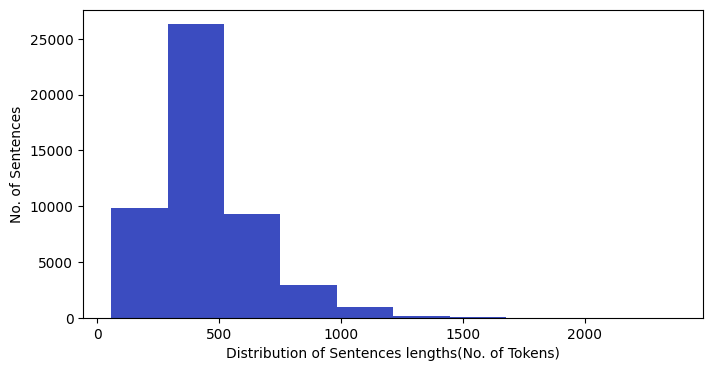

In [27]:
lens = [len(sen) for sen in input_ids]
d = pd.DataFrame({'Label' : labels, 'text' : input_ids, 'Len' : lens})

plt.figure(figsize=(8, 4))
d.Len.plot.hist(color=[cmap(0.0), cmap(0.25), cmap(0.65), cmap(0.9), cmap(1.0)])
plt.xlabel("Distribution of Sentences lengths(No. of Tokens)")
plt.ylabel("No. of Sentences")
plt.show()

In [35]:
print(f"There are {len(d[d['Len'] <= 512])} sentences with token count less than 512.")

There are 35703 sentences with token count less than 512.


In [36]:
d = d[d['Len'] <= 512]

input_ids = d['text'].values
labels = d['Label'].values

inputs = [torch.tensor(sublist) for sublist in input_ids]

**Cool...We also solved our data imbalance problem**

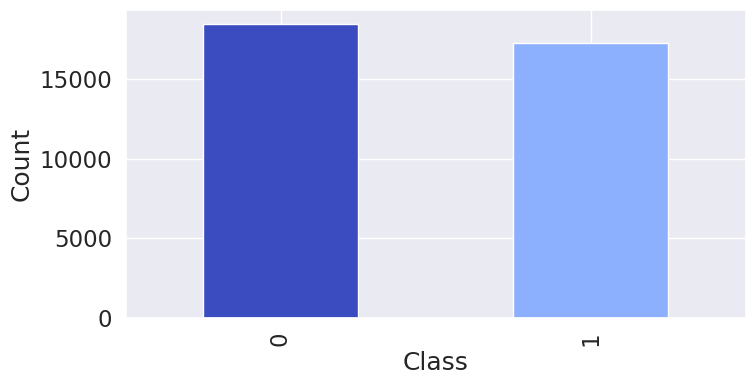

In [217]:
plt.figure(figsize=(8, 4))
d.Label.value_counts().plot.bar(color=[cmap(0.0), cmap(0.25), cmap(0.65), cmap(0.9), cmap(1.0)])
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

> Since there are variable lengths in the input sentences, we will pad the sentences to the maximum length of a sentence.
> In BERT vocabulary [PAD] is encoded with 0. so we will simply append the 0 to the shorter sentences.

In [40]:
MAX_LEN = 512

print(f"\nPadding/truncating all sentences to {MAX_LEN} values...")

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long",
                          value=0, truncating="post", padding="post")

print('\nDone.')


Padding/truncating all sentences to 512 values...

Padding token: "[PAD]", ID: 0

Done.


**Masking the input tokens as 1 for the real token, 0 for the padded token**

In [41]:
attention_masks = []

for sent in input_ids:
    att_mask = [int(token_id > 0) for token_id in sent]

    attention_masks.append(att_mask)

In [42]:
#Splitting the datasets into train and validation
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels,
                                                            random_state=219778, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=219778, test_size=0.1)

In [43]:
#Making them torch tensors
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [44]:
#Creating a Tensor dataset
batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

**Loading our beloved BERT from the transformers library**

In [45]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False
)

# Tell pytorch to run this model on the GPU.
model.cuda()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

**BERT base is 110M parameter model. we will be finetuning to update all these weights**

In [46]:
import torch
from torch import nn

def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

# Print the number of parameters
total_params, trainable_params = count_parameters(model)
print(f"Total Parameters: {total_params}")
print(f"Trainable Parameters: {trainable_params}")

Total Parameters: 109483778
Trainable Parameters: 109483778


In [47]:
#Initializing the optimizer
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8
                )

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [48]:
#Learning rate scheduler
from transformers import get_linear_schedule_with_warmup

epochs = 2

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [49]:
#To evaluate the accuracy during the training
import numpy as np

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [50]:
#To estimate the training time for a fixed number of batches
import time
import datetime

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    
    return str(datetime.timedelta(seconds=elapsed_rounded))

**Here goes the fun part...Training**

In [52]:
import random

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        if step % 50 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
            
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()

        outputs = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask,
                    labels=b_labels)

        loss = outputs[0]

        total_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)

    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(format_time(time.time() - t0)))


    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    for batch in validation_dataloader:

        batch = tuple(t.to(device) for t in batch)

        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():

            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask)

        logits = outputs[0]

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        tmp_eval_accuracy = flat_accuracy(logits, label_ids)

        eval_accuracy += tmp_eval_accuracy

        nb_eval_steps += 1

    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 2 ========
Training...
  Batch    50  of  2,009.    Elapsed: 0:00:43.
  Batch   100  of  2,009.    Elapsed: 0:01:25.
  Batch   150  of  2,009.    Elapsed: 0:02:07.
  Batch   200  of  2,009.    Elapsed: 0:02:49.
  Batch   250  of  2,009.    Elapsed: 0:03:31.
  Batch   300  of  2,009.    Elapsed: 0:04:12.
  Batch   350  of  2,009.    Elapsed: 0:04:54.
  Batch   400  of  2,009.    Elapsed: 0:05:36.
  Batch   450  of  2,009.    Elapsed: 0:06:18.
  Batch   500  of  2,009.    Elapsed: 0:07:00.
  Batch   550  of  2,009.    Elapsed: 0:07:41.
  Batch   600  of  2,009.    Elapsed: 0:08:23.
  Batch   650  of  2,009.    Elapsed: 0:09:05.
  Batch   700  of  2,009.    Elapsed: 0:09:47.
  Batch   750  of  2,009.    Elapsed: 0:10:29.
  Batch   800  of  2,009.    Elapsed: 0:11:10.
  Batch   850  of  2,009.    Elapsed: 0:11:52.
  Batch   900  of  2,009.    Elapsed: 0:12:34.
  Batch   950  of  2,009.    Elapsed: 0:13:16.
  Batch 1,000  of  2,009.    Elapsed: 0:13:58.
  Batch 1,050  of

**Let's validate our fine tuned model with a seperate test set.**

In [184]:
test = pd.read_csv(r'test-dataset/test set.csv')

In [185]:
test['Predicted Label'] = None
for i, sent in enumerate(test.text.values):
    tokens = tokenizer(sent, truncation=True, padding=True, return_tensors="pt")
    tokens.to(device)
    
    with torch.no_grad():
        logits = model(**tokens).logits

    probs = torch.nn.functional.softmax(logits, dim=-1).to(device)
    
    threshold = 0.5

    test['Predicted Label'][i] = 1 if probs[0, 1] > threshold else 0

In [186]:
from sklearn.metrics import roc_auc_score

# Assuming you have two columns: 'label' and 'predicted_label' in the DataFrame 'test'
auc_score = roc_auc_score(test['label'], test['Predicted Label'])

print(f'AUC Score: {auc_score}')

AUC Score: 0.9900124843945068


In [208]:
sentences = ["""To : TEACHER_NAME

Community service is a very good plan , community services need more reliable citizens to depend on . Community service doesn't actually have to be just cleaning up litter , community service can be helped in many ways , Such as Cleaning up Beaches , streets/parks , or helping at an after school program . Community service is a very good idea .

Some Beaches are usually filled with Dirty Garbage that people leave behind when there on their vacations . At beaches you see bear bottles , can's of soda's , plates , and even wrappers that can affect our environment and animals . Streets are full with things that people throw out of their cars even if its against the law . Littering our streets can be a big conflict to our drivers , anything can happen to the wheels while there driving . Parks can be a fun place for kids to spend their time but also there dirty with candy wrappers , ice cream wrappers all these sort of things should be improved to help in our community .

Middle School teenagers are more active , and have more time then these adults . Most teenagers do not work , these teenagers have time to spend on helping our community . Some of my friends think that Community service is a waste of time , that they have better things to do then just pick up garbage , i used to think that i picked up enough garbage at home . But when i realized and asked about community service , my room is nothing compared to the garbage out there in just one street block . It's their decision to perform community service if they want to or not .

Helping in an after school program can be very fun for teenagers . They can get to show kids and give them a heads up on what high school is like . teenagers can volunteer to help students after school on their homework , problems and for the best part they can also at the same time get their High-school hours . Kids will have fun play and learn things everyday from these Community programs .

These are some of hundreds of ways that teenagers can be part of Community services , they can ask questions or find put more by searching what community service is like .It can make a Big change in their lives .

- Love , One of your wonderful 8th

Graders , STUDENT_NAME <3""", 
            
"""First impressions are a fundamental part of human interaction, and they can greatly impact how people perceive and interact with each other. However, changing these initial perceptions can be challenging and difficult. In this essay, I will explore the reasons why first impressions are almost impossible to change and provide examples of how natural first impressions come to people, the role of the mind when forming first impressions, and how people are not prepared for the first impressions they experience.

First impressions are often formed based on physical appearance, body language, and tone of voice. These initial perceptions can be influenced by a variety of factors, including cultural background, personal experiences, and societal expectations. For example, a person may form a negative first impression of someone based on their race or ethnicity, even if they have never met them before. Similarly, a person may form a positive first impression of someone based on their physical appearance, even if they have never met them before.

The role of the mind in forming first impressions is also important. Our brains are wired to quickly process and categorize information, and this can lead to the formation of initial perceptions. When we meet someone new, our brains may quickly categorize them based on their appearance, behavior, and other cues. This categorization can be based on our past experiences and expectations, and it can be difficult to overcome.

People are also not prepared for the first impressions they experience. We often form our first impressions based on limited information and incomplete context. For example, we may meet someone at a social event and form a first impression based on their behavior and appearance, without knowing their background or personality. This can lead to misunderstandings and miscommunications, as we may not accurately understand the person's intentions or motivations.

In conclusion, first impressions are almost impossible to change because they are formed based on physical appearance, body language, and tone of voice, and are influenced by our past experiences, cultural background, and societal expectations. Our brains are wired to quickly process and categorize information, and we are not always prepared for the first impressions we experience. It is important to be aware of these factors and to make an effort to form accurate and fair first impressions, in order to build positive and meaningful relationships with others.""",
            """Education is a journey that spans a lifetime, an ongoing process that extends far beyond the confines of formal classrooms. I wholeheartedly agree that education is a life-long pursuit, an ever-evolving experience that enriches individuals and society at large.

Firstly, the world is in a constant state of change, with advancements in technology, science, and culture shaping the landscape of knowledge. To remain relevant and adaptable, individuals must engage in continuous learning. Take, for example, the rapid evolution of technology. What is considered cutting-edge today may become outdated tomorrow. Thus, embracing a life-long learning mindset ensures that individuals stay abreast of new developments and maintain a competitive edge in their respective fields.

Moreover, the challenges and complexities of the modern world demand a diverse skill set that extends beyond the traditional classroom setting. Life-long learning allows individuals to acquire practical skills, problem-solving abilities, and critical thinking that are essential for navigating the complexities of work and personal life. Continuous education fosters resilience, adaptability, and the ability to thrive in an ever-changing environment.

Furthermore, life-long learning is not solely about professional development; it encompasses personal growth and enrichment. Learning new languages, exploring different cultures, or delving into the arts can provide individuals with a broader perspective and a deeper understanding of the world. Education, in this broader sense, contributes to personal fulfillment and a well-rounded life.

In conclusion, the notion that education is a life-long process is not only valid but increasingly vital in our fast-paced and dynamic world. Embracing continuous learning is not just a choice; it is a necessity for personal and professional success. Whether acquiring new skills, staying informed about the latest advancements, or nurturing personal interests, the journey of education is an ongoing adventure that enriches individuals and, collectively, society as a whole. Life-long learning is the compass that guides individuals through the ever-changing landscape of knowledge, ensuring that they are not merely spectators but active participants in the unfolding story of human progress.
"""]
true_lables = ['Real', 'Fake', 'Fake']
print("Predictions...\n")
for i, sent in enumerate(sentences):
    tokens = tokenizer(sent, truncation=True, padding=True, return_tensors="pt")
    tokens.to(device)
    
    with torch.no_grad():
        logits = model(**tokens).logits

    probs = torch.nn.functional.softmax(logits, dim=-1).to(device)
    
    threshold = 0.5
    
    print(f"\nSentence {i+1}: \n \n{sentences[i][:100]}...{sentences[i][-100:]}")
    print(f'\nPredicted Label: {"Fake" if probs[0, 1] > threshold else "Real"}')
    print(f'\nTrue Label: {true_lables[i]}')

Predictions...


Sentence 1: 
 
To : TEACHER_NAME

Community service is a very good plan , community services need more reliable cit...an make a Big change in their lives .

- Love , One of your wonderful 8th

Graders , STUDENT_NAME <3

Predicted Label: Real

True Label: Real

Sentence 2: 
 
First impressions are a fundamental part of human interaction, and they can greatly impact how peopl...ate and fair first impressions, in order to build positive and meaningful relationships with others.

Predicted Label: Fake

True Label: Fake

Sentence 3: 
 
Education is a journey that spans a lifetime, an ongoing process that extends far beyond the confine...at they are not merely spectators but active participants in the unfolding story of human progress.


Predicted Label: Fake

True Label: Fake


In [183]:
#Saving the model
torch.save(model, '/kaggle/working/BERT Finetuned model/pytorch_model.bin')
tokenizer.save_pretrained('/kaggle/working/BERT Finetuned model/')

('/kaggle/working/BERT Finetuned model/tokenizer_config.json',
 '/kaggle/working/BERT Finetuned model/special_tokens_map.json',
 '/kaggle/working/BERT Finetuned model/vocab.txt',
 '/kaggle/working/BERT Finetuned model/added_tokens.json')